In [7]:
%run setup.py

In [2]:
stars = pd.read_csv(rootpath+'numax/sample/samples_rg.csv')
vrard = pd.read_csv(rootpath+'numax/sample/vrard+16.csv')
stars = stars.merge(vrard[['KIC', 'DPi1', 'e_DPi1']], on='KIC', how='left')

idx = stars['DPi1'].notna() & stars['e_DPi1'].notna()
stars = stars[idx].reset_index(drop=True)

modes = pd.read_csv(rootpath+'numax/sample/modes_rg.csv')

In [3]:
def quantile(x, q, weights=None):
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if weights is None:
        return np.percentile(x, 100.0 * q)
    else:
        weights = np.atleast_1d(weights)
        idx = np.argsort(x, axis=0)

        res = []
        for i in range(x.shape[1]):
            sw = weights[idx[:,i]]
            cdf = np.cumsum(sw)[:-1]
            cdf /= cdf[-1]
            cdf = np.append(0, cdf)
            res.append(np.interp(q, cdf, x[idx[:,i],i]))
        return np.array(res).T

In [17]:
suf = '_ms'
original_cols = ['star_mass', 'radius', 'Dnu_freq', 'Teff', 'amlt', 'FeH', 'numax_scaling', 'fov_shell', 'fov_core', 'Yinit', 'Zinit']
to_append_cols = ['mass'+suf, 'radius'+suf, 'Dnu'+suf, 'Teff'+suf, 'amlt'+suf, 'feh'+suf, 'numax'+suf, 'fov_shell'+suf, 'fov_core'+suf, 'Yinit'+suf, 'Zinit'+suf]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)

    data = h5py.File(filepath, 'r')

    chi2_Teff = (data['Teff'][:]-star['Teff'])**2.0 / star['e_Teff']**2.0
    chi2_mh = (data['FeH'][:]-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_lum = (data['luminosity'][:]-star['luminosity'])**2.0 / star['e_luminosity']**2.0
    # chi2_DPi1 = (data['delta_Pg'][:]-star['DPi1'])**2.0 / star['e_DPi1']**2.0
    
    chi2 = data['chi2_seismic'][:] + chi2_Teff + chi2_mh + chi2_lum #+ chi2_DPi1

    results = quantile(np.array([data[col][:] for col in original_cols]).T, (0.16, 0.5, 0.84), weights=np.exp(-chi2/2.))

    var = list(results[1,:])
    e_var = list((results[2,:] - results[0,:])/2.)

    return var + e_var

r = list(tqdm(get_context("fork").Pool(8).imap(multi, stars.loc[:].iterrows()), total=len(stars), position=0))
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)

100%|██████████| 953/953 [00:10<00:00, 90.77it/s] 


In [18]:
suf = '_ma'
original_cols = ['star_mass', 'radius', 'Dnu_freq', 'Teff', 'amlt', 'FeH', 'numax_scaling', 'fov_shell', 'fov_core',  'Yinit', 'Zinit']
to_append_cols = [col+suf for col in ['mass', 'radius', 'Dnu', 'Teff', 'amlt', 'feh', 'numax', 'fov_shell', 'fov_core', 'Yinit', 'Zinit']]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)

    data = h5py.File(filepath, 'r')
    
    # k = (2.2-1.9)/(0.5+0.8)
    # b = 2.2 - k*0.5
    
    # k, b = 0.56, 2.19
    k, b = 0.68, 2.15
    e_amlt = 0.05

    chi2_amlt = (data['amlt'][:] - (k*data['FeH'][:] + b))**2.0 / e_amlt**2.0
    chi2_Teff = (data['Teff'][:]-star['Teff'])**2.0 / star['e_Teff']**2.0
    chi2_mh = (data['FeH'][:]-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_lum = (data['luminosity'][:]-star['luminosity'])**2.0 / star['e_luminosity']**2.0
    # chi2_DPi1 = (data['delta_Pg'][:]-star['DPi1'])**2.0 / star['e_DPi1']**2.0
    
    chi2 = data['chi2_seismic'][:] + chi2_Teff + chi2_mh + chi2_lum  + chi2_amlt #+ chi2_DPi1

    results = quantile(np.array([data[col][:] for col in original_cols]).T, (0.16, 0.5, 0.84), weights=np.exp(-chi2/2.))

    var = list(results[1,:])
    e_var = list((results[2,:] - results[0,:])/2.)

    return var + e_var

r = list(tqdm(get_context("fork").Pool(8).imap(multi, stars.loc[:].iterrows()), total=len(stars), position=0))
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)

100%|██████████| 953/953 [00:10<00:00, 94.66it/s] 


In [19]:
suf = '_my'
original_cols = ['star_mass', 'radius', 'Dnu_freq', 'Teff', 'amlt', 'FeH', 'numax_scaling', 'fov_shell', 'fov_core',  'Yinit', 'Zinit']
to_append_cols = [col+suf for col in ['mass', 'radius', 'Dnu', 'Teff', 'amlt', 'feh', 'numax', 'fov_shell', 'fov_core', 'Yinit', 'Zinit']]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)

    data = h5py.File(filepath, 'r')
    
    # k, b = 0.56, 2.19
    k, b = 0.68, 2.15
    e_amlt = 0.05
    
    e_Yinit = 0.02
    Yp, dY_dZ = 0.25, 1.2
    # Yp, dY_dZ = 0.24, 1.5

    chi2_Yinit =  (data['Yinit'][:]-(Yp + dY_dZ*data['Zinit'][:]))**2.0 / e_Yinit**2.0
    chi2_amlt = (data['amlt'][:] - (k*data['FeH'][:] + b))**2.0 / e_amlt**2.0
    chi2_Teff = (data['Teff'][:]-star['Teff'])**2.0 / star['e_Teff']**2.0
    chi2_mh = (data['FeH'][:]-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_lum = (data['luminosity'][:]-star['luminosity'])**2.0 / star['e_luminosity']**2.0
    # chi2_DPi1 = (data['delta_Pg'][:]-star['DPi1'])**2.0 / star['e_DPi1']**2.0
    

    chi2 = data['chi2_seismic'][:] + chi2_Teff + chi2_mh + chi2_lum  + chi2_amlt + chi2_Yinit #+ chi2_DPi1

    results = quantile(np.array([data[col][:] for col in original_cols]).T, (0.16, 0.5, 0.84), weights=np.exp(-chi2/2.))

    var = list(results[1,:])
    e_var = list((results[2,:] - results[0,:])/2.)

    return var + e_var

r = list(tqdm(get_context("fork").Pool(8).imap(multi, stars.loc[:].iterrows()), total=len(stars), position=0))
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)

100%|██████████| 953/953 [00:09<00:00, 95.47it/s] 


In [21]:
for suf in ['_ms', '_ma', '_my']:
    stars['fnumax'+suf] = stars['numax']/stars['numax'+suf]
    stars['e_fnumax'+suf] = ((stars['e_numax']/stars['numax'])**2.0 
         + (stars['e_numax'+suf]/stars['numax'+suf])**2.0)**0.5 * stars['fnumax'+suf]

    stars['fDnu'+suf] = stars['Dnu']/stars['Dnu'+suf]
    stars['e_fDnu'+suf] = ((stars['e_Dnu']/stars['Dnu'])**2.0 
         + (stars['e_Dnu'+suf]/stars['Dnu'+suf])**2.0)**0.5 * stars['fDnu'+suf]


#     stars['g'+suf] = stars['mass'+suf]/stars['radius'+suf]**2.
#     stars['e_g'+suf] = ((stars['e_mass'+suf]/stars['mass'+suf])**2.0 
#          + (2*stars['e_radius'+suf]/stars['radius'+suf])**2.0)**0.5 * stars['g'+suf]


In [22]:

def get_binned_median(xdata, ydata, bins):
    '''
    return median vals and the standand deviation of the median for given data and a bin.

    Input:
        xdata: array-like[N,]
        ydata: array-like[N,]
        bins: array-like[Nbin,]

    Output:
        xcs: array-like[Nbin,]
            center of each bin
        medians: array-like[Nbin,]
            median values of ydata in each bin
        stds: array-like[Nbin,]
            stds of the median of ydata in each bin

    '''
    
    Nbin = len(bins)-1
    medians, stds = [np.zeros(Nbin) for i in range(2)]
    for ibin in range(Nbin):
        idx = (xdata>bins[ibin]) & (xdata<=bins[ibin+1]) & (np.isfinite(xdata)) & (np.isfinite(ydata))
        if np.sum(idx)==0:
            medians[ibin], stds[ibin] = np.nan, np.nan
        else:
            medians[ibin] = np.median(ydata[idx])
            stds[ibin] = 1.253*np.std(ydata[idx])/np.sqrt(np.sum(idx))
    xcs = (bins[1:]+bins[:-1])/2.
    return xcs, medians, stds

# plot fnumax vs mass, numax, feh, amlt

0

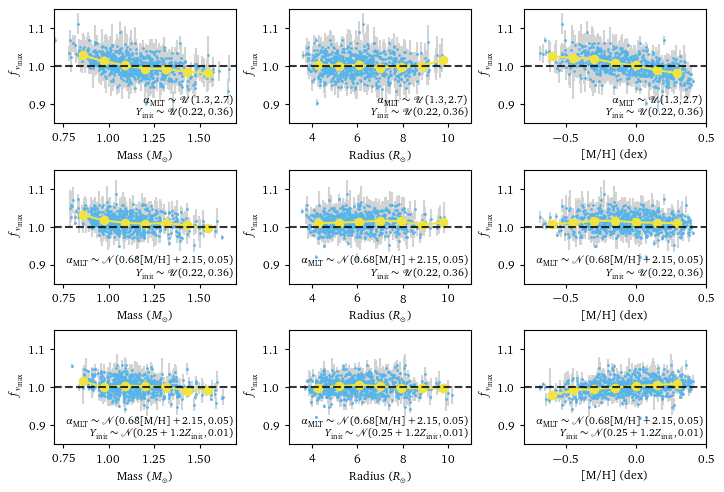

In [46]:
fig, axes = plt.subplots(figsize=figsize(column='double', ratio=0.45/2*3), nrows=3, ncols=3, squeeze=False, constrained_layout=True)

sufs = ['_ms', '_ma', '_my']
# k, b = 0.5646359, 2.1529336
# legends = [r'$L$, [M/H], $T_{\rm eff}$, $\nu_{l=0}$, $\nu_{l=2}$', 
#            r'$L$, [M/H], $T_{\rm eff}$, $\nu_{l=0}$, $\nu_{l=2}$'+'\n'+r'$\alpha_{\rm MLT}=0.56{\rm [M/H]}+2.15$']
legends = [r'$\alpha_{\rm MLT} \sim {\mathcal{U}} (1.3, 2.7)$'+'\n'+r'$Y_{\rm init} \sim {\mathcal{U}} (0.22, 0.36)$',
           r'$\alpha_{\rm MLT} \sim {\mathcal{N}} (0.68{\rm [M/H]}+2.15, 0.05)$'+'\n'+r'$Y_{\rm init} \sim {\mathcal{U}} (0.22, 0.36)$',
           r'$\alpha_{\rm MLT} \sim {\mathcal{N}} (0.68{\rm [M/H]}+2.15, 0.05)$'+'\n'+r'$Y_{\rm init} \sim {\mathcal{N}} (0.25 + 1.2 Z_{\rm init}, 0.01)$']

vals = ['mass', 'radius', '[M/H]', ] #'amlt', ]
labels = [r'Mass ($M_\odot$)', r'Radius ($R_\odot$)', '[M/H] (dex)', r'$\alpha_{\rm MLT}$'] #r'$\nu_{\rm max}$ ($\mu$Hz)'
xlims = [[0.7, 1.7], [3, 11], [-0.8, 0.5], [1.7, 2.6]]

for irow in range(len(sufs)):
    suf = sufs[irow]

    med = np.median(stars['DPi1']/stars['Dnu']**0.26)
    std = np.std(stars['DPi1']/stars['Dnu']**0.26)

    idx = ((stars['e_fnumax'+suf]/stars['fnumax'+suf]) < 0.3) & \
        (stars['radius'+suf]<11.) & (np.abs(stars['DPi1']/stars['Dnu']**0.26-med) < 0.8*std)

    sample = stars.loc[idx, :].reset_index(drop=True)

    for icol in range(len(vals)):

        ax = axes[irow, icol]

        if vals[icol] == '[M/H]':
            xval, xlabel = vals[icol], labels[icol]
        else:
            xval, xlabel = vals[icol]+suf, labels[icol]
        yval, ylabel = 'fnumax'+suf, r'$f_{\nu_{\rm max}}$'
        
        ax.errorbar(sample[xval].to_numpy(), sample[yval].to_numpy(), 
                    yerr=sample['e_'+yval].to_numpy(), linestyle='none', marker='.', ms=2, ecolor='lightgray', color=colors[1], rasterized=True) # 'royalblue'

        rmin, rmax = xlims[icol][0], xlims[icol][1]
        r = rmax-rmin
        xcs, medians, stds = get_binned_median(sample[xval].to_numpy(), 
                                                  sample[yval].to_numpy(), 
                                                  bins=np.linspace(rmin+r*0.1, rmax-r*0.1, 8)
                                                 )
        ax.errorbar(xcs, medians, yerr=stds, linestyle='-', marker='o', ecolor='k', color=colors[3], zorder=10) # 'crimson'

        # if irow==1:
        ax.set_xlabel(xlabel)
        
        # if icol==0:
        ax.set_ylabel(ylabel)

        ax.set_ylim(0.85, 1.15)
        ax.set_xlim(*xlims[icol])
        ax.axhline(1, linestyle='--', color='k', alpha=0.8, zorder=20)
        ax.text(0.98, 0.05, legends[irow], transform=ax.transAxes, ha='right', va='bottom', fontsize=fontsize-1)
        
filename = 'Fig.6_fnumax.pdf'
plt.savefig(filename, dpi=300)
os.system(to_overleaf(filename, 'figures'))